# Customer Analysis

In [1]:
import pandas as pd
from operator import attrgetter
from datetime import timedelta, datetime

import plotly.express as px
import plotly.graph_objects as go

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns

import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
# Preprocessed data
olist = pd.read_csv('../raw/olist.csv', parse_dates=['order_purchase_timestamp'])
olist_geolocation = pd.read_csv('../raw/olist_geolocation_dataset.csv')

## 1. Customer distribtion over Brazil

#### 1.2. Customer distribution by purchase time

We will classify Olist customers into two type: `new` and `repeat customers`. Repeat customers are people who buy from Olist time and time again and would be considered loyal customers. In this context, we will consider only those who make consecutive orders after **at least one day** as repeat customers (people making multiple orders in one day will not fall in this type).

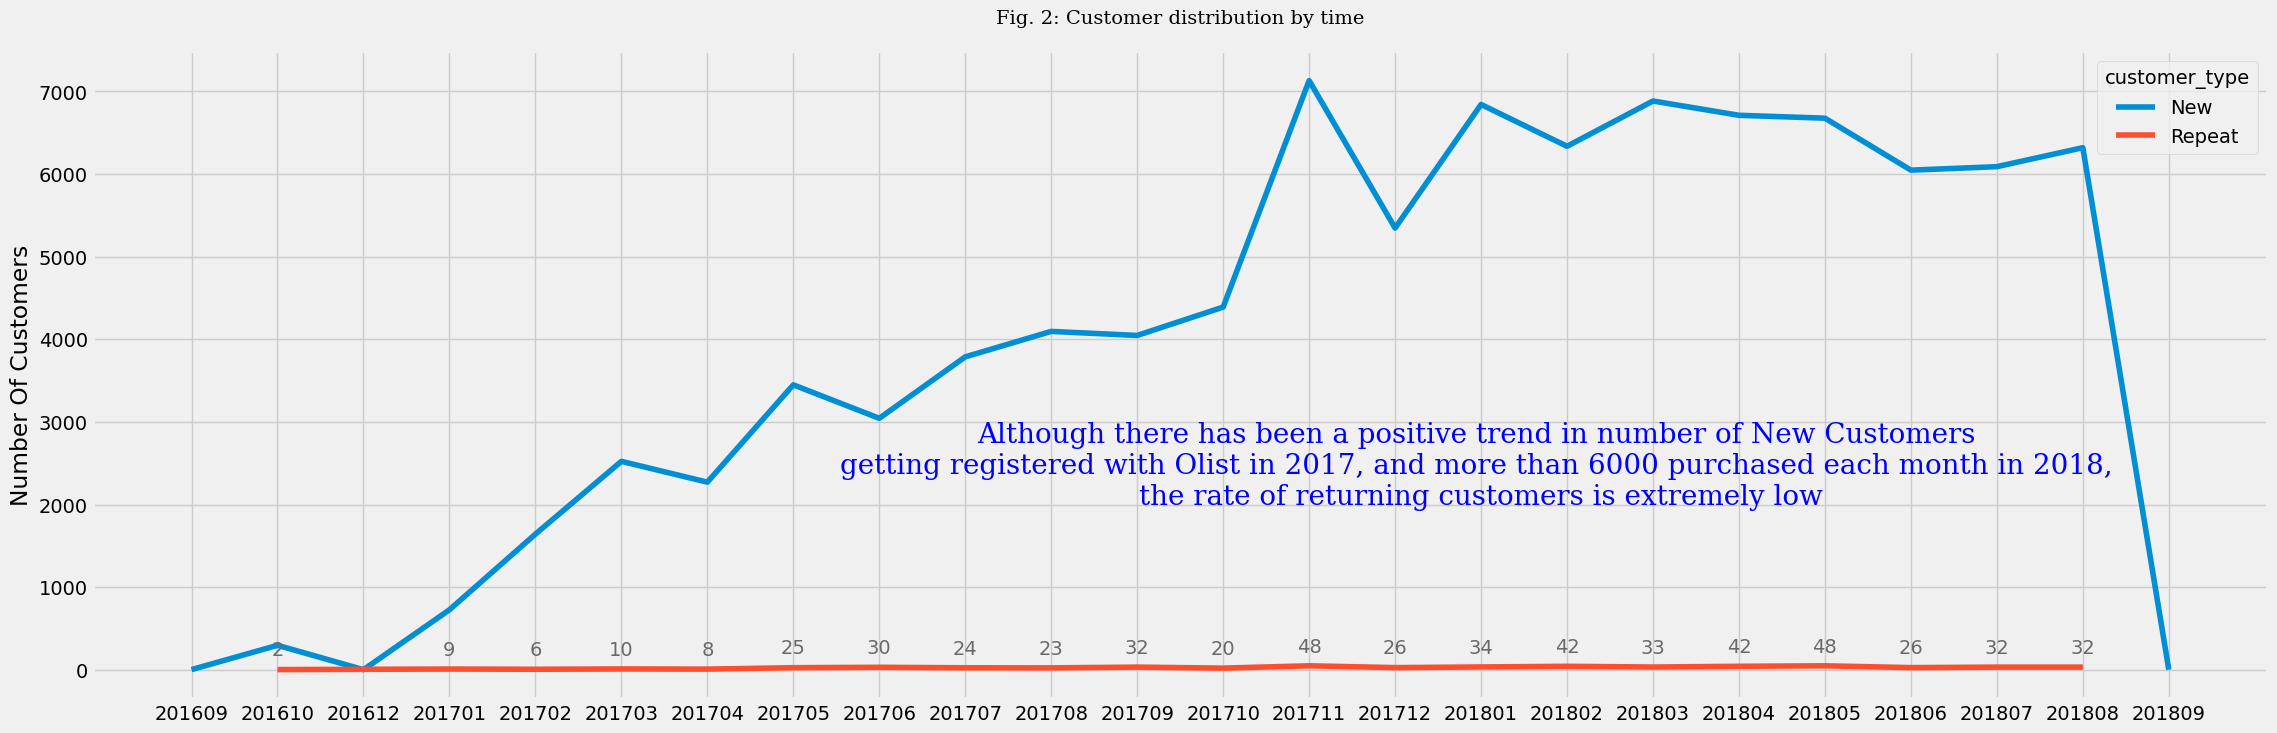

In [3]:
olist['order_purchase_date'] = olist.order_purchase_timestamp.apply(lambda x: pd.to_datetime(x, format="%Y-%m-%d"))
customer_by_time = olist.groupby(['customer_unique_id', 'order_purchase_year_month']).agg({'order_purchase_date': ['nunique', 'first']})
customer_by_time.columns = ['num_of_orders', 'order_first_purchase_date']
customer_by_time['customer_type'] = customer_by_time['num_of_orders'].apply(lambda x: 'Repeat' if x > 1 else 'New')

customer_by_time = customer_by_time.reset_index().groupby(['order_purchase_year_month', 'customer_type'])['customer_unique_id'].count().reset_index()
customer_by_time['order_purchase_year_month'] = customer_by_time.order_purchase_year_month.astype(str)

# Plot
plt.figure(figsize=(25, 8))
ax = sns.lineplot(data=customer_by_time, x='order_purchase_year_month', y='customer_unique_id', hue='customer_type')
for x, y in customer_by_time.loc[customer_by_time.customer_type == 'Repeat', ['order_purchase_year_month', 'customer_unique_id']].values:
    ax.annotate(str(y), xy=(x, y), textcoords='offset points', xytext=(0, 10), ha='center', color='dimgrey')

ax.set_title('Fig. 2: Customer distribution by time', size=14, font='serif', pad=20)
ax.set_xlabel('')
ax.set_ylabel('Number Of Customers')
comment = 'Although there has been a positive trend in number of New Customers \ngetting registered with Olist in 2017, and more than 6000 purchased each month in 2018, \nthe rate of returning customers is extremely low'
plt.text(x='201801', y=2000, s=comment, family='serif', color='b', fontsize=20, ha='center')
plt.show()

## 2. Cohort Analysis

A cohort is a group of users who share some common properties such as sign-up, first purchase date, interests, acquisition channel, etc. Cohort retention analysis (or cohort analysis) is the process of tracking user engagement with the product over time. However, instead of looking at the user population as a whole, it looks at specific user groups linked to specific events or timeframes. 

Cohort analysis could help you boost conversions, estimate Customer Lifetime Value more precisely, and prevent customer churn, which leads to stable revenue and sustainable growth.

In [4]:
# Determine the user's cohort group (based on their first order)
df = olist[['customer_unique_id', 'order_id', 'order_purchase_timestamp', 'product_category_name', 'customer_state']].drop_duplicates()
df['OrderMonth'] = df['order_purchase_timestamp'].dt.to_period('M')
df['Cohort'] = df.groupby('customer_unique_id')['order_purchase_timestamp'].transform('min').dt.to_period('M') 

# Create cohort dataframe
df_cohort = df.groupby(['Cohort', 'OrderMonth']).agg(n_customers=('customer_unique_id', 'count')).reset_index(drop=False)
df_cohort['PeriodIndex'] = (df_cohort.OrderMonth - df_cohort.Cohort).apply(attrgetter('n'))

cohort_pivot = df_cohort.pivot_table(index='Cohort', columns='PeriodIndex', values='n_customers')
cohort_pivot = cohort_pivot.iloc[4:-1,:-5] # only select data from 2017-02 for a well-documented journey

cohort_size = cohort_pivot.iloc[:,0]
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)

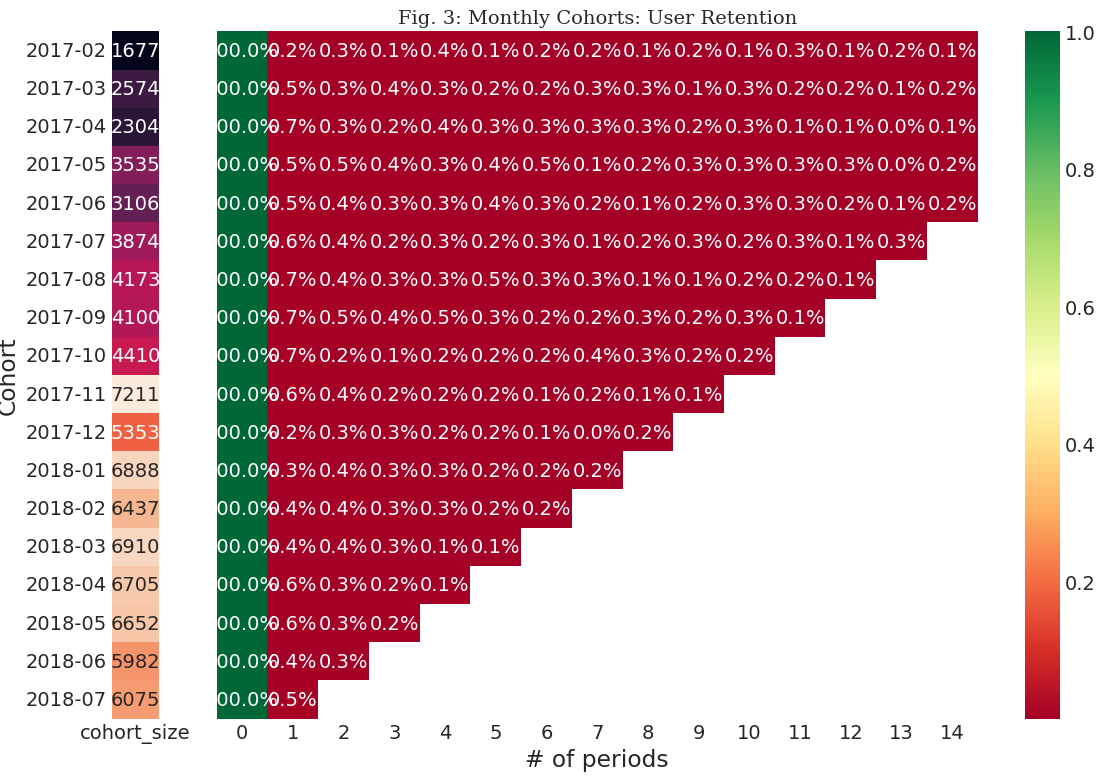

In [5]:
# Plot retention matrix as a heatmap
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 20]})
    
    # retention matrix
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.1%', 
                cmap='RdYlGn', 
                ax=ax[1])
    ax[1].set_title('Fig. 3: Monthly Cohorts: User Retention', fontsize=14, family='serif')
    ax[1].set(xlabel='# of periods',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                ax=ax[0])

    fig.tight_layout()
# Note that we will see this chart again in the dashboard with state selection

## 3. RFM
RFM analysis numerically ranks a customer in each of these three categories, generally on a scale of 1 to 5 (the higher the number, the better the result). The "best" customer would receive a top score in every category. time

Theoretically we will have segments like below:

* LOW VALUES: Customers who are less active than others, not very frequent buyer/visitor and generates very low or zero net revenue.
  
* MID VALUES: In the middle of everything. Using our platform oftently (but not as much as our High Values), fairly frequent and generates moderate revenue.
  
* HIGH VALUES: The group we don’t want to lose. High Revenue, Frequency and low Inactivity.

Depending on each specific marketing tactic, we may have more smaller and detailed segments.

We will calculate R, F and M dimensions as following:
- `Recency` — number of days since the last purchase
- `Frequency` — number of transactions made over a given period
- `Monetary` — amount spent over a given period of time

In [6]:
snapshot_date = olist.order_purchase_date.max() + timedelta(days=1)
rfm = (
    olist
    .groupby('customer_unique_id').agg({
        'order_purchase_date': lambda x: (snapshot_date - x.max()).days,
        'order_id': 'count',
        'payment_value': 'sum'})
    .rename(columns={
        'order_purchase_date': 'Recency',
        'order_id': 'Frequency',
        'payment_value': 'Monetary'})
)
rfm.head()

,Recency,Frequency,Monetary
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,116,1,141.90
0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,27.19
0000f46a3911fa3c0805444483337064,542,1,86.22
0000f6ccb0745a6a4b88665a16c9f078,326,1,43.62
0004aac84e0df4da2b147fca70cf8255,293,1,196.89


#### 3.1. Distribution of each dimension

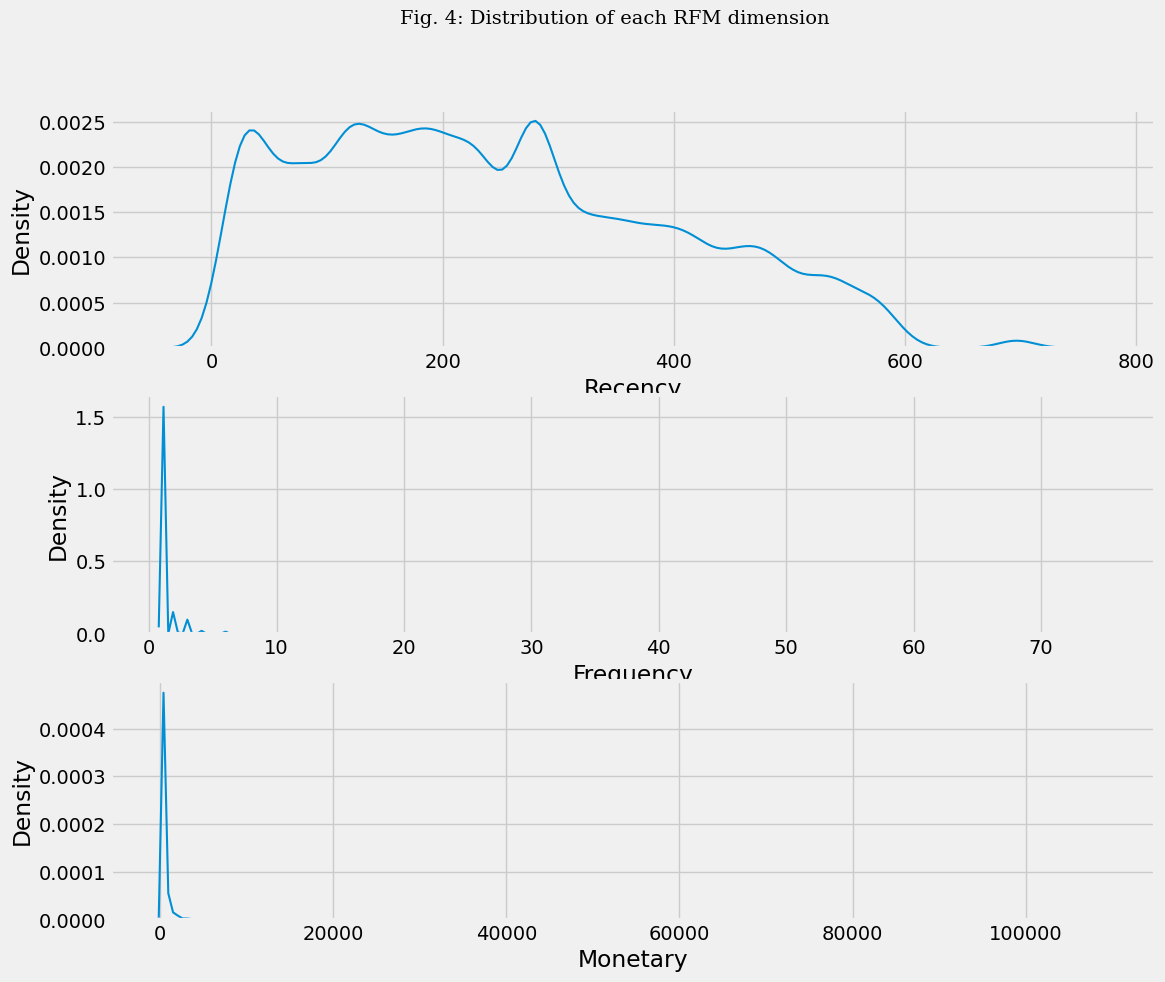

In [7]:
plt.figure(figsize=(12,10))
plt.subplot(3, 1, 1)
sns.kdeplot(rfm['Recency'], lw=1.5)
plt.subplot(3, 1, 2)
sns.kdeplot(rfm['Frequency'], lw=1.5)
plt.subplot(3, 1, 3)
sns.kdeplot(rfm['Monetary'], lw=1.5)
plt.suptitle('Fig. 4: Distribution of each RFM dimension', size=14, font='serif')
plt.show()

We could see that most customers mainly buy goods with low frequency and not high value. This can be explained because most (>99%) of Olist's customers are new customers.

#### 3.2. Labelling

Note that most frequency is 1, so that we could not evenly split `Frequency` into equal groups.

In [8]:
r_labels = range(4, 0, -1)
r_groups = pd.qcut(rfm['Recency'], q=4, labels=r_labels)

f_labels = range(1, 5)
f_groups = pd.cut(rfm['Frequency'], bins=[0, 1, 2, 3, max(rfm['Frequency'])], labels=f_labels)

m_labels = range(1, 5)
m_groups = pd.qcut(rfm['Monetary'], q=4, labels=m_labels)

rfm = rfm.assign(
    R=r_groups.values, 
    F=f_groups.values,
    M=m_groups.values
)
rfm.head()

,Recency,Frequency,Monetary,R,F,M
customer_unique_id,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,116,1,141.90,4,1,3
0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,27.19,4,1,1
0000f46a3911fa3c0805444483337064,542,1,86.22,1,1,2
0000f6ccb0745a6a4b88665a16c9f078,326,1,43.62,2,1,1
0004aac84e0df4da2b147fca70cf8255,293,1,196.89,2,1,3


#### 3.3. RFM Segmentation

Identify Upselling and Cross selling opportunities

In [9]:
rfm['RFM_segment'] = rfm[['R', 'F', 'M']].astype(str).apply(''.join, axis=1).astype(int)
rfm['RFM_score'] = rfm[['R', 'F', 'M']].sum(axis=1)

def rfm_segment_label(df): # Refer to Wondaris tables
    '''Generate segment label'''
    level = ''
    if df['RFM_score'] >= 10: # at least one dimension = 4 (top)
        level = 'VVIP' 
    elif (df['RFM_score'] >= 8) and (df['M'] == 4):
        level = 'Big Spenders'
    elif df['RFM_score'] >= 6:
        if df['F'] >= 2:
            level = 'Loyal Customers'
        else:
            level = 'Potential Loyalists'
    elif (df['RFM_score'] >= 5) and (df['R'] >= 2) or (df['F'] >= 2):
            level = 'Lagging Customers'
    elif (df['RFM_score'] >= 4) and (df['R'] == 1):
        level = 'Hibernating - Almost Lost'
    else: # RFM_score <= 3 (1, 1, 1)
        level = 'Churned Customers'
        
    return level

rfm['Customer Segment'] = rfm.apply(rfm_segment_label, axis=1)

# Calculate average values for each Customer Segment, and return a size of each segment 
rfm_segment = rfm.groupby('Customer Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count'],
}).round(1)
rfm_segment.columns = ['mean_Recency', 'mean_Frequency', 'mean_Monetary', 'segment_size']

segment_to_action = {
    'VVIP': 'No Price Incentives / Offer Limited edition and Premium loyalty programs',
    'Big Spenders': 'Upsell most expensive items',
    'Loyal Customers': 'Loyalty programs / Cross-sell',
    'Potential Loyalists': 'Cross-sell recommendations and Discount coupons',
    'Lagging Customers': 'Price incentives / Limited coupons / Free delivery / Gift with Purchase',
    'Hibernating - Almost Lost': 'Aggressive price incentives',
    'Churned Customers': 'Don\'t spend too much trying to re-acquire / What can we do better Survey'
}

rfm_segment['Marketing Action'] = rfm_segment.index.map(segment_to_action)
rfm_segment = rfm_segment.reset_index()
rfm_segment

,Customer Segment,mean_Recency,mean_Frequency,mean_Monetary,segment_size,Marketing Action
0,Big Spenders,174.6,1.6,510.4,11292,Upsell most expensive items
1,Churned Customers,370.8,1.0,44.0,11256,Don't spend too much trying to re-acquire / Wh...
2,Hibernating - Almost Lost,455.5,1.0,115.5,10543,Aggressive price incentives
3,Lagging Customers,238.2,1.1,64.9,12051,Price incentives / Limited coupons / Free deli...
4,Loyal Customers,290.8,2.2,231.3,5361,Loyalty programs / Cross-sell
5,Potential Loyalists,175.4,1.0,167.4,39218,Cross-sell recommendations and Discount coupons
6,VVIP,112.9,3.4,1052.2,3675,No Price Incentives / Offer Limited edition an...


From here, we can see that **only a small percentage (~22%)** of our customers are in the top tier RFM levels (`VVIP`, `Loyal` & `High-value` customers). Olist must do something right to maintain their loyalty. There are some opportunities as follow:

* We can Upsell high end products to Big Spenders
* 
We can Cross Sell complimentary products to Loyal and Best Customer


**The other 78% will need some work.**

*1. Potential Loyalists*

42% of our customers falls in this category. They are highly potential to enter our loyal customer segments, discounts for future purchases are very suitable for this audience.

*2. Lagging Customers*

They are showing promising signs with quantity and value of their purchase but it has been a while since their last purchases. Let’s target them with their wishlist items, a limited time offer discount and/or a free delivery.

*3. Hibernating Almost Lost*

They made some initial purchase but have not seen them since. Let’s spend some resource to build our brand awareness with them.

*4. Churned Customers*

Poorest performers of our RFM model. They might have went with our competitors for now and will require a different activation strategy to win them back. We can see many things to improve our business through surveying this customer group.

#### 3.4. Visualization

*a. RFM segmentation*

In [10]:
rfm_pivot = (rfm[['R', 'F', 'M']]
             .astype(int)
             .groupby(['R', 'F'])['M'].count()
             .reset_index()
             .pivot(index='R', columns='F', values='M')
)

heatmap_data = go.Heatmap(
    z=rfm_pivot.values,
    y=rfm_pivot.columns,
    x=rfm_pivot.index,
    showscale=True, 
    colorbar=dict(title='Number Of Customers'),
    hovertemplate='Recency: %{x}<br>Frequency: %{y}<br>Number Of Customers: %{z}<extra></extra>'
)

heatmap_layout = go.Layout(
    width=600, height=400,
    title=dict(text='Fig 5: RFM segmentation', font=dict(size=15, family='serif')),
    xaxis={'title':'Recency', 'categoryarray': [1, 2, 3, 4]},
    yaxis={'title': 'Frequency', 'categoryarray': [1, 2, 3, 4]},
    hovermode='closest'
)

fig = go.Figure(data=heatmap_data, layout=heatmap_layout)
fig.show()

*b. Customer Segmentation*

In [11]:
rfm_segment['Segment Tiers'] = rfm_segment['Customer Segment'].apply(lambda x: 'Top Tier Segments' if x in ['VVIP', 'Loyal Customers', 'Big Spenders'] 
                                                                     else 'Low Tier Segments')

fig = px.treemap(rfm_segment.rename(columns={'segment_size': 'Segment Size'}), 
                 path=[px.Constant("All Segments"), 'Segment Tiers', 'Customer Segment'], 
                 values='Segment Size', 
                 color='Segment Size', color_continuous_scale='RdBu'
                )

fig.update_layout(
    margin = dict(t=50, l=25, r=25, b=25),
    title=dict(text='Fig 6: Customer Segmentation', font=dict(size=15, family='serif')),
    width=800, height=500,
)
fig.show()

## 4. K-Means clustering

We have carefully crafted the clusters based on the RFM score and segmented customers. Now lets apply a Machine Learning approach to identify if there are any hidden segments we can find from clusters.

#### 4.1. Preprocess data and apply K-Means clustering model (draft)

In [12]:
# Filter R, F, M dimension only
rfm_df = rfm[['Recency', 'Frequency', 'Monetary']]

# Scale data
rfm_df_log = rfm_df.apply(np.log) 
scaler = StandardScaler().fit(rfm_df_log)
rfm_normalized = scaler.transform(rfm_df_log)
rfm_normalized = pd.DataFrame(data=rfm_normalized, index=rfm_df.index, columns=rfm_df.columns)

# Modeling
kmeans = KMeans(n_clusters=5, random_state=42).fit(rfm_normalized)
cluster_labels = kmeans.labels_

# Results
rfm_df_with_cluster = rfm_df.assign(Cluster=cluster_labels)
rfm_df_with_cluster_grouped = rfm_df_with_cluster.groupby(['Cluster']).agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
}).round(1)

rfm_df_with_cluster_grouped

Recency Frequency Monetary       
           mean      mean     mean  count
Cluster                                  
0          34.5       1.1    156.7  11160
1         367.7       1.0     72.2  27763
2         253.2       2.6    603.1  12812
3         134.0       1.0     75.5  19103
4         278.2       1.0    310.6  22558

#### 4.2. Find the best k

I will use **the elbow method** to find `the best k` for our data. The selected k should be at the “elbow”, i.e. the point of inflection on the curve.

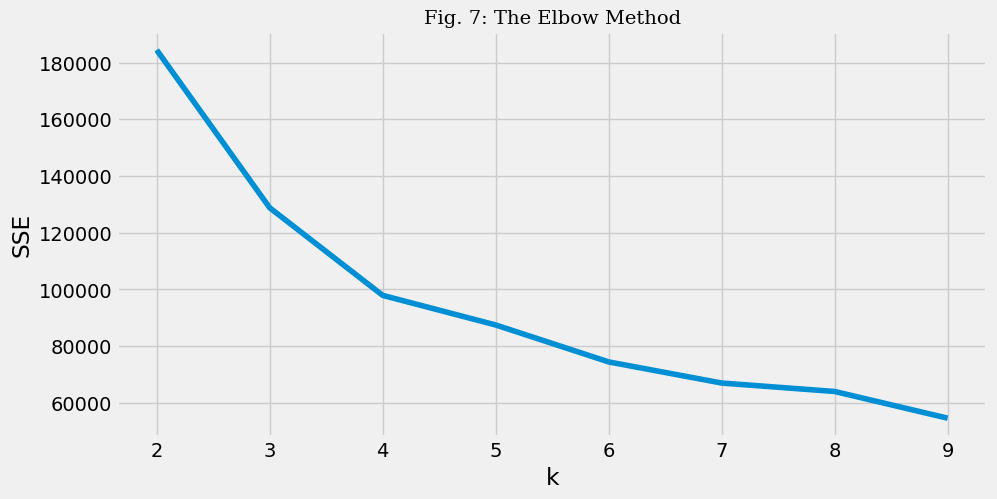

In [13]:
sse = {}
for k in range(2, 10):  
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(rfm_normalized)
    sse[k] = kmeans.inertia_
plt.figure(figsize=(10, 5))

plt.title('Fig. 7: The Elbow Method', size=14, font='serif')
plt.xlabel('k')
plt.ylabel('SSE')
plt.plot(sse.keys(), sse.values())
plt.show()

Because of the elbow is not so clear here, we could use **the Silhouette method** in combination with the Elbow for a more confident decision.

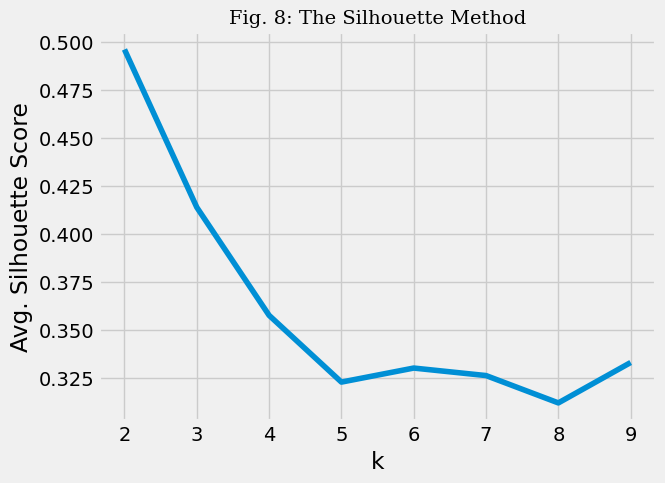

In [14]:
silhouette_avg = {}
for k in range(2, 10):  
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(rfm_normalized)
    cluster_labels = kmeans.labels_
    if len(np.unique(cluster_labels)) > 1: # To avoid unexpected error with single cluster when calculating silhouette score
        silhouette_avg[k] = silhouette_score(rfm_normalized, cluster_labels) # note that this calculation will takes several minites to finish
    
plt.title('Fig. 8: The Silhouette Method', size=14, font='serif')
plt.xlabel('k')
plt.ylabel('Avg. Silhouette Score')
plt.plot(silhouette_avg.keys(), silhouette_avg.values())
plt.show()
# k = 6

#### 4.3. Final K-Means clustering model

We will create final K-Means clustering model with `k=6`

In [15]:
kmeans = KMeans(n_clusters=6, init='k-means++', random_state=42).fit(rfm_normalized)
cluster_labels = kmeans.labels_

rfm_df_with_cluster = rfm_df.assign(Cluster=cluster_labels)
rfm_df_with_cluster_grouped = rfm_df_with_cluster.groupby(['Cluster']).agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
}).round(1)

#### 4.4. Calculate relative importance of each attribute within each cluster

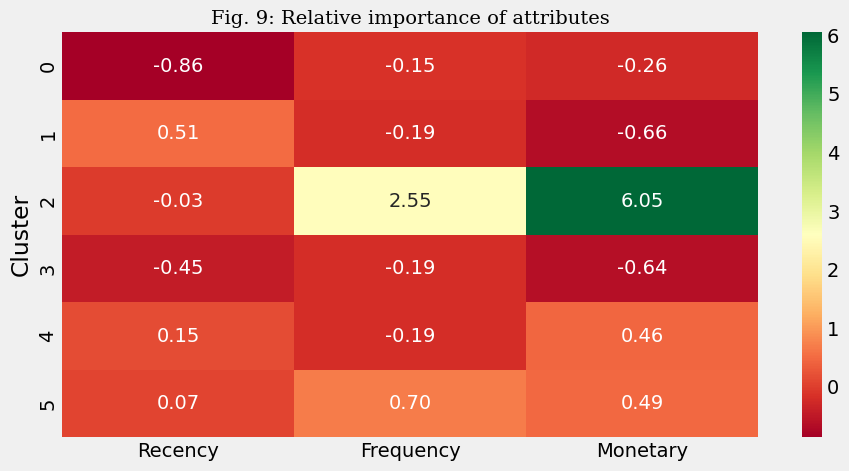

In [16]:
cluster_avg = rfm_df_with_cluster.groupby(['Cluster']).mean() 
population_avg = rfm_df.mean()
relative_imp = cluster_avg / population_avg - 1

plt.figure(figsize=(10, 5))
plt.title('Fig. 9: Relative importance of attributes', size=14, font='serif')
sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap='RdYlGn')
plt.show()

Each cluster of customers places a different emphasis on our 4 features:

- **Cluster 0**: We almost lost them
  
It performs poorly across R, F, and M. we will need to design campaigns to activate them again.

- **Cluster 1**: Potential loyalists

Customers have purchased recently with high amount goods but not frequent --> we might have some discount campaign to stimulate placing further orders

- **Cluster 2**:
  
They shopped with us recently but have not spend as much or as frequently as we would like them to — perhaps some personalized products might help to maximize their lifetime value and come back to purchase?

- **Cluster 3**: Ideal customers

It has the highest Monetary value mean, low Recency mean, and the highest frequency mean.

- **Cluster 4**: Lagging customers

They have purchased with high Frequency and medium M but it has been a while after their last transactions --> Let’s target them with their wishlist items, a limited time offer discount and/or a free delivery.

- **Cluster 5**: 

It has spent quite a fair amount with us but has not shopped with us in the 3–4 months — We will need to do something before we lose them!

#### Compare RFM vs. K-Means clustering

Both RFM & K-Means model are  good methods to segment customers (based on Recency, Frequency and Monetary dimensions). If want a simple, fully explainable and easy to customize approach, RFM is the way to go. However, K-Means model will be very helpful in case you want to explore other potential customer segments, or rely on information fields other than just R, F, M.
 
In the next analysis, we will explain more about explainability in predictive analysis.